In [76]:
# Import python packages and modules
import pandas as pd
import ipywidgets as w
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import clear_output

In [77]:
# Read data and basic cleansing

# Read the playoff data set
stats = pd.read_csv('2018-2019-Playoff-NBAStats.csv').dropna(axis='columns', how='all')
# stats.head(5)

# Rename the columns in a more readable format based on csv file
auxlist = pd.read_csv('rename_columns.txt', header=None)
auxlist.columns = ['New Column Names']
stats.columns = auxlist['New Column Names'].tolist()

The following diagram displays the average minutes by position not including players that were on court more than a minute.

[Text(0,0.5,'Average Minutes Per Game')]

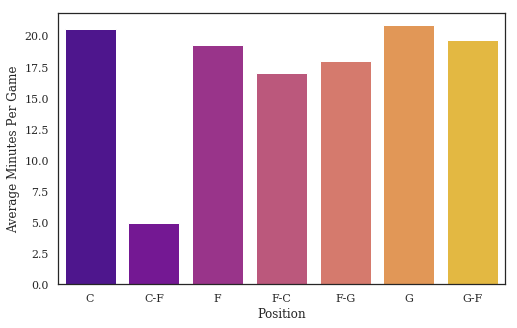

In [78]:
# Simple analysis that displays average minutes per position

analysis1= stats[stats['Minutes Per Game']>1.0].groupby('Position').mean().reset_index(inplace=False) \
.iloc[:,0:4]
analysis1.select_dtypes(include ='float64').round(2)
# set figures common aesthetics
sns.set(style='white', font='serif')
fig, ax = plt.subplots(figsize = (8,5))

# Remember: seaborn barplot returns an axis object not a figure
ax = sns.barplot(x ='Position', y ='Minutes Per Game', data = analysis1, palette ='plasma')
ax.set(ylabel='Average Minutes Per Game')

The following diagram displays the highest scoring player per team order by PPG.

The line depicts the contribution (in 0-100% scale) of each top player points to the team's points.
$ Ratio = \frac{Player's Points per Game}{Team's Points Per Game} \times 100 $

The higher this ratio, the more the team is dependent to this player. Ideally an optimal combination would be a player with a **high** PPG value (i.e. bar) and **low** ratio (i.e. line). This would be translated that other players contribute to the team's offence, making this team difficult to face.

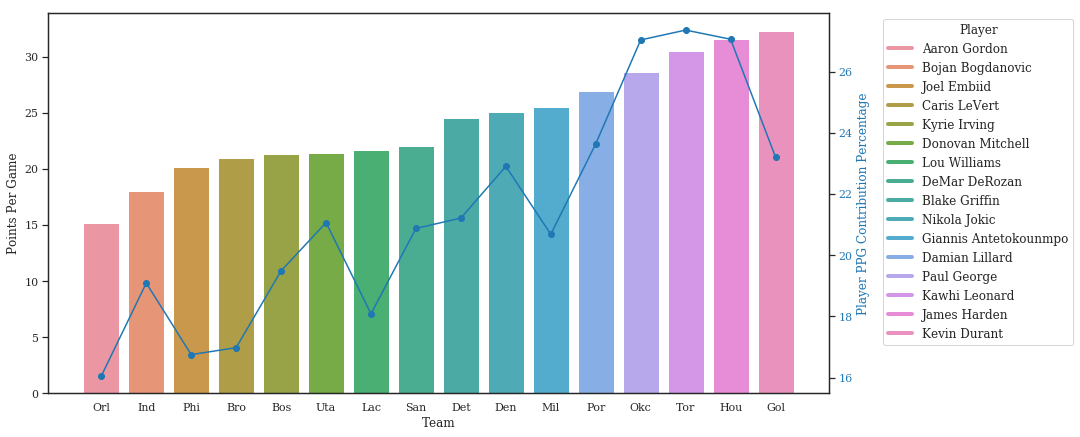

In [79]:
# Leading players of each team in scoring
# Here idx is a Series object of True / False for each player depending on whether the condition is met
idx = stats.groupby(['Team'])['Points Per Game'].transform(max) == stats['Points Per Game']
# Based on the idx returned we get the player's name (not only Team and Points)
top_player_ppg = stats[idx][['Team', 'Full Name', 'Points Per Game']]

# Calculate each team's average points per game
team_ppg = stats.groupby('Team').sum().reset_index()[['Team', 'Points Per Game']]  \
.rename(columns = {'Points Per Game': 'Team PPG'})

# Merge data frames to have one source of input
df = pd.merge(top_player_ppg, team_ppg, on='Team').sort_values('Points Per Game')

# Share of each player's PPG to team's PPG 
df['Player To Team PPG Ratio'] = (df['Points Per Game'] / df['Team PPG'])*100  # This is percentage

# Will use it later for the legend
auxlist = df['Full Name'].tolist()

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(14,7))

# Create bar plot
ax = sns.barplot(x='Team', y="Points Per Game", data=df)

# Get the color of each bar
bars = [r for r in ax.get_children() if type(r)==Rectangle]
barcolors = [c.get_facecolor() for c in bars[:-1]] # I think the last Rectangle is the background.

# Create a tuple with the name and the color for each team
legend_elements = []
for element, color in zip(auxlist, barcolors):
    legend_elements.append(Line2D([0], [0], color=color, lw=4, label=element))
                              
# Create the legend and locate it outside the plot. The handles are matched with the color of each bar
ax.legend(handles=legend_elements, bbox_to_anchor=(1.32, 1), loc='upper right', fontsize='medium', title='Player')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Player PPG Contribution Percentage', color=color)  
ax2.plot(df['Team'], df['Player To Team PPG Ratio'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.show()

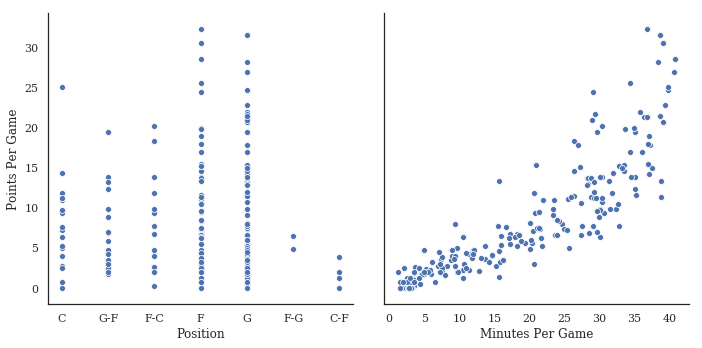

In [80]:
# stats.columns = stats.columns.str.strip()
g = sns.pairplot(stats, y_vars=["Points Per Game"], x_vars=["Position", "Minutes Per Game"], height=5)

In [81]:
# Define an output widget to capture outpur
output = w.Output()

# Get the distinct values of the 'Position' column using set
st = set(stats["Position"].tolist())
st.remove("F-G")

# Define a drop down list and
dropdown_pos = w.Dropdown(
    description='Position:',
    options=st,
    layout=w.Layout(width="150px")
)

display(dropdown_pos)

# Define an event handler to define what the change in the value will do
def dropdown_pos_eventhandler(change):
    output.clear_output()
    with output:        
        analysis = stats[stats.Position == change.new]
        # Plot a linear regression diagram of order 2
        sns.lmplot(x="Minutes Per Game", y="Points Per Game", hue="Position"
                   , data=analysis
                   , height=6
                   , aspect=1.5
                   , order=2, ci=None, scatter_kws={"s": 50}
                   # we do not need different markets since we set it to one selection with drop down
#                    , markers=['o', 'x', '^', '+', '*', '8']
                  )
        
        plt.ylim(bottom=0)
        plt.xlim(left=0)
        plt.show()
        
# use the observe function to capture changes in the drop down list
dropdown_pos.observe(dropdown_pos_eventhandler, names='value')
display(output)

Dropdown(description='Position:', layout=Layout(width='150px'), options=('G-F', 'C', 'F', 'G', 'C-F', 'F-C'), …

Output()

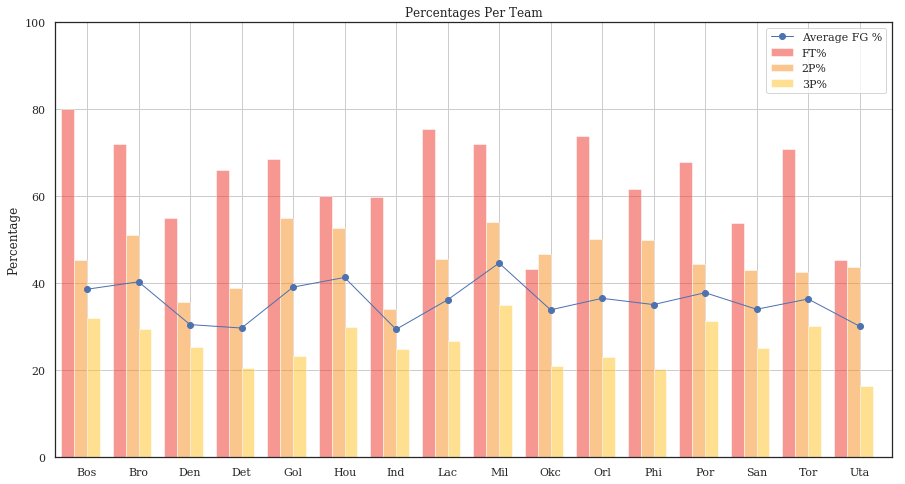

In [82]:
# Prepare data: calculate average of three main metrics FT%, 2P%, 3P%
# as_index will result in adding Team as a column 
analysis2 = stats.groupby('Team', as_index=False)[['FT%','2P%','3P%']].mean()
for colname, coltype in analysis2.dtypes.iteritems():    
    analysis2[colname] = analysis2[colname].apply(lambda x: x*100) if coltype == 'float64' else analysis2[colname]

# Get the number of total bar groups (in this case 16). Instead of FT% we could use any other column
pos = list(range(len(analysis2['FT%'])))
width = 0.25  # width of each bar 
    
# Plotting
fig, ax = plt.subplots(figsize=(15,8))

# Create a bar with FT% data,
# in position pos,
plt.bar(pos,         
        analysis2['FT%'], 
        # of width
        width, 
        # with alpha 0.5 (sets the transparency level)
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label
        label=analysis2['Team'][0]) 

# Create a second bar with 2P% data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],  # this is a list see more on list comprehension        
        analysis2['2P%'],        
        width,         
        alpha=0.5,         
        color='#F78F1E',         
        label=analysis2['Team'][1]) 

# Create a bar with 3P% data,
plt.bar([p + width*2 for p in pos],         
        analysis2['3P%'],         
        width,         
        alpha=0.5,         
        color='#FFC222',         
        label=analysis2['Team'][2]) 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Percentages Per Team')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(analysis2['Team'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)  # if not set the edges will be too far away
plt.ylim([0, 100])

# Add the FG average (i.e. both 2P and 3P) of each team
analysis2['avgFG%'] = (analysis2['2P%'] + analysis2['3P%']) / 2
ax.plot(ax.get_xticks()
        , analysis2[['avgFG%']].values
        , linestyle='-'
        , marker='o'
        , color='b'
        , linewidth=1.0
        , label='FG% Percentage')

# Set the legend with hard - coded labels
plt.legend(['Average FG %', 'FT%', '2P%', '3P%'] , loc='best')

# Add grid lines in the background
plt.grid()
# Show the plot
plt.show()

In [83]:
# This function is used to populate a drop down list from a dataframe column 
def dropdown_from_dataframe_sorted(df, col_name):
    return sorted(set(df[col_name].tolist()))

The following analysis depicts how team player each player is, based on:
- the ratio of "Assists To Turnover" to "Average Minutes on Court"
- usage ratio* 
of each player

*Is an estimate of the percentage of team plays used by a player while he was on the floor. A high percentage, i.e. circle in the diagram, indicates that the many of the team's offences went through the specific player.

A low "Assists to Turnover" ratio comparing to the time on the floor and the usage percentage indicates a non - team player. If the player in not also within the team's top scores (not depicted in this diagram), this is an indication of a player that while in court the contribution to the team's effort is negative.

Axis:
- x-axis: Minutes (average) per Game
- main y-axis: "Assists to Turnover" ratio => the higher the better

Bubble:
- size of the bubble: usage ratio, the greater it means that more percentage of a team's effort are taken by specific player

Widgets:
- MPG Greater Than: Filter on the minutes per game
- Teams: Select two or more teams to compare with


In [84]:
# Define and basic style of widgets
style = {'description_width': '150px'}

# Define widgets section

# Multiple selection. The option are taken by another function in another cell
teams = w.SelectMultiple(
    description='Teams:',
    options=dropdown_from_dataframe_sorted(stats, 'Team'),  \
    value=list(dropdown_from_dataframe_sorted(stats, 'Team')[:1])
)

# Drop down with the minutes on court
dropdown_mpg_threshold = w.Dropdown(
    description='MPG Greater Than:',
    options=range(1,49),
    layout=w.Layout(width="Auto"),
    style=style    
)

# Group threshold related widgets
threshold_widgets = w.HBox(
    children=[dropdown_mpg_threshold, teams],
    layout=w.Layout(width="100%")
)

# Apply button
apply_button = w.Button(description='Apply')

# Put them all together in a vertical box for alignement purposes
all = w.VBox([threshold_widgets, apply_button])

# Define two widget outputs one for the data and one for the plot
out = w.Output()
plot_out = w.Output()

def on_button_clicked(_):        
    # linking function with output
    with out:
        # what happens when we press the button                
        clear_output()
        # data set is filtered by: drop down value, selected teams, and have avg of turnovers <> 0 
        analysis = stats[(stats['Minutes Per Game'] >= int(dropdown_mpg_threshold.value)) &  \
                          (stats['Turnovers Per Game'] != 0) &  \
                          (stats['Team'].isin(teams.value))
                         ]  \
        [['Full Name','Team', 'Minutes Per Game', 'Assists Per Game', 'Turnovers Per Game', 'Usage Percentage']]        
        
        # calculate assists to turnover ratio
        analysis['Assists To Turnover Ratio'] = analysis['Assists Per Game'] / analysis['Turnovers Per Game']
        display(analysis)
    
    # linking diagram with another output
    with plot_out:
        # always clear output to re-draw plot each time the button clicks with new data
        clear_output()
        plt.subplots(figsize=(15,8))
        sns.scatterplot(x='Minutes Per Game', y='Assists To Turnover Ratio', hue = 'Team'  \
                        , size='Usage Percentage', sizes=(30, 200), data=analysis)
        
        # Add labels beside each point of the diagram (using the zip function)
        for x,y,z in zip(analysis['Minutes Per Game'].tolist(),  \
                         analysis['Assists To Turnover Ratio'].tolist(),  \
                         analysis['Full Name'].tolist()
                        ):
            label = z
            
            # Annotate each label next to point
            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,5), # distance from text to points (x,y)
                         ha='left') # horizontal alignment can be left, right or center        
        
        plt.show()
                            
apply_button.on_click(on_button_clicked)

# Separate data and plot in two different tabs
tab = w.Tab()
tab.set_title(0, 'Data')  # set title of tab 1
tab.set_title(1, 'Plot')  # set title of tab 2
tab.children = [out, plot_out]  # define the content of the tab widget, each element will be added sequentially

# show everything within a dashboard
dashboard = w.VBox([all, tab])

display(dashboard)